Compute correction for dust extinction due to the extinction within the galaxy (should be a function of inclination).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
import astropy.constants as const
import astropy.units as u

from hyperfit.linfit import LinFit

import time

import corner

import pickle

import matplotlib.pyplot as plt
#UNCOMMENT FOR 3D PLOTS
# %matplotlib widget

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Galaxies

In [3]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/'

gals_filename = 'SGA-2020_iron_Vrot_VI_photsys.fits'

gals = Table.read(gals_directory + gals_filename)

In [4]:
gals[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,132.22926444835167,2.692954944764243,N
55,SGA-2020 55,PGC1203947

# Empirical internal dust extinction correction

Can we find (and correct for) any correlation between the axis ratio and the color of the galaxies?

## Calculate the "known" photometric corrections

### Survey offsets

In [5]:
sys_corr, sys_corr_err = BASS_corr(gals['PHOTSYS'])

### Dust corrections

In [6]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [7]:
dust_corr, dust_corr_err = MW_dust(gals['RA'], gals['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [8]:
# Flip NaN values to 0
dust_corr_err[np.isnan(dust_corr_err)] = 0

### $K$-corrections

In [9]:
zg0 = gals['Z_DESI'] >= 0

In [10]:
kcorr_zg0 = k_corr(gals['Z_DESI'][zg0], 
                   [gals['G_MAG_SB26'][zg0], gals['R_MAG_SB26'][zg0], gals['Z_MAG_SB26'][zg0]], 
                   [gals['G_MAG_SB26_ERR'][zg0], gals['R_MAG_SB26_ERR'][zg0], gals['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1)

In [11]:
kcorr = np.zeros((len(gals), 3))
kcorr[zg0] = kcorr_zg0

## Apply "known" corrections

In [12]:
gals['G_MAG_SB26_CORR'] = gals['G_MAG_SB26'] - dust_corr[0] + sys_corr + kcorr[:,0]
gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26'] - dust_corr[1] + sys_corr + kcorr[:,1]
gals['Z_MAG_SB26_CORR'] = gals['Z_MAG_SB26'] - dust_corr[2] + sys_corr + kcorr[:,2]

In [13]:
gals['G_MAG_SB26_ERR_CORR'] = np.sqrt(gals['G_MAG_SB26_ERR']**2 + dust_corr_err[0]**2 + sys_corr_err**2)
gals['R_MAG_SB26_ERR_CORR'] = np.sqrt(gals['R_MAG_SB26_ERR']**2 + dust_corr_err[1]**2 + sys_corr_err**2)
gals['Z_MAG_SB26_ERR_CORR'] = np.sqrt(gals['Z_MAG_SB26_ERR']**2 + dust_corr_err[2]**2 + sys_corr_err**2)

## Convert $R_{26}$ to kpc

In [14]:
dist = Distance(z=np.abs(gals['Z_DESI']), cosmology=Planck18)

In [15]:
rng = np.random.default_rng()

N_samples = 1000

dist_err = np.empty(len(dist))*u.Mpc

for i in range(len(dist_err)):
    
    z_desi_random = rng.normal(np.abs(gals['Z_DESI'][i]), 
                               gals['ZERR_DESI'][i], 
                               N_samples)
    
    d_random = Distance(z=z_desi_random, cosmology=Planck18)
    
    dist_err[i] = np.std(d_random)

In [16]:
gals['R26_kpc'] = dist.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)
gals['R26_kpc_err'] = dist_err.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)

## Correlation between color and axis ratio?

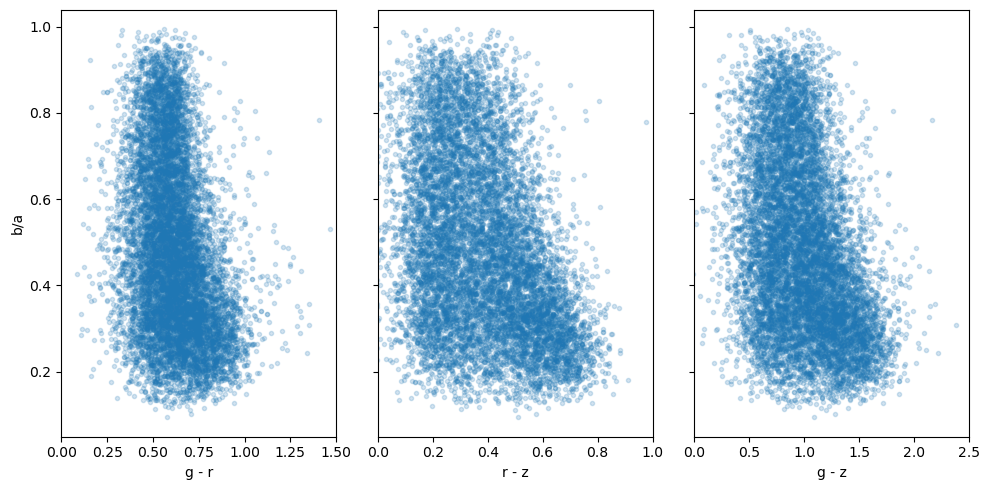

In [17]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'] - gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([0, 1.5])

ax[1].plot(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r - z')
ax[1].set_xlim([0, 1])

ax[2].plot(gals['G_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('g - z')
ax[2].set_xlim([0, 2.5]);

## Correlation between magnitude and axis ratio?

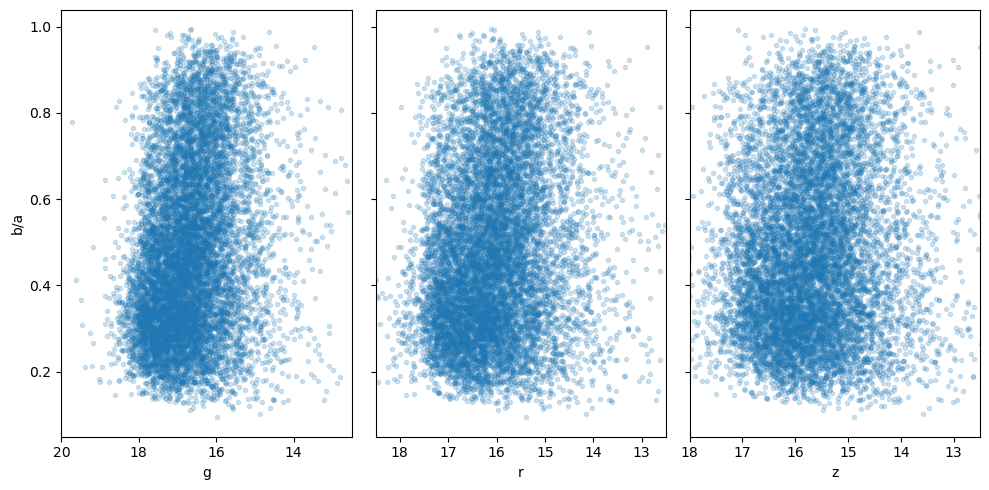

In [18]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([20, 12.5])

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5]);

## Correlation between magnitude, $R_{26}$, and axis ratio?

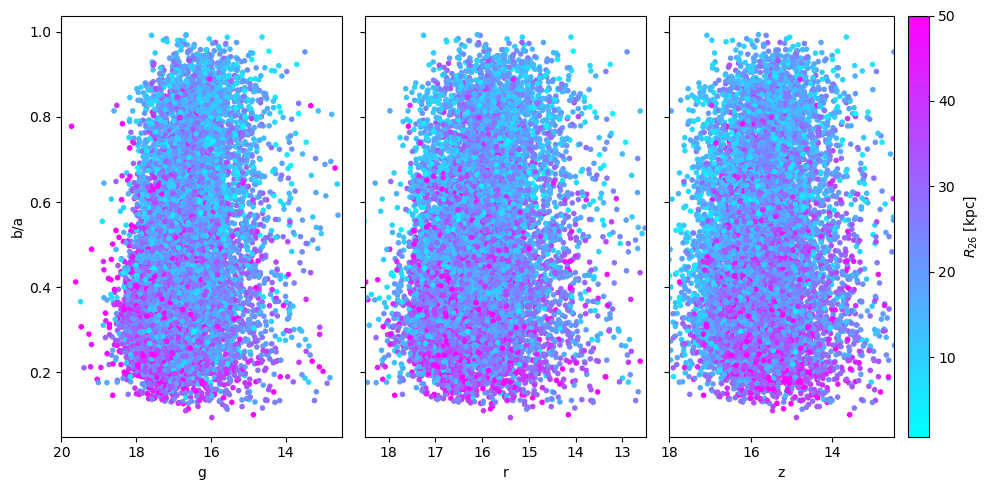

In [19]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].scatter(gals['G_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([20, 12.5])

ax[1].scatter(gals['R_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

zplot = ax[2].scatter(gals['Z_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5])

plt.colorbar(zplot, label='$R_{26}$ [kpc]');

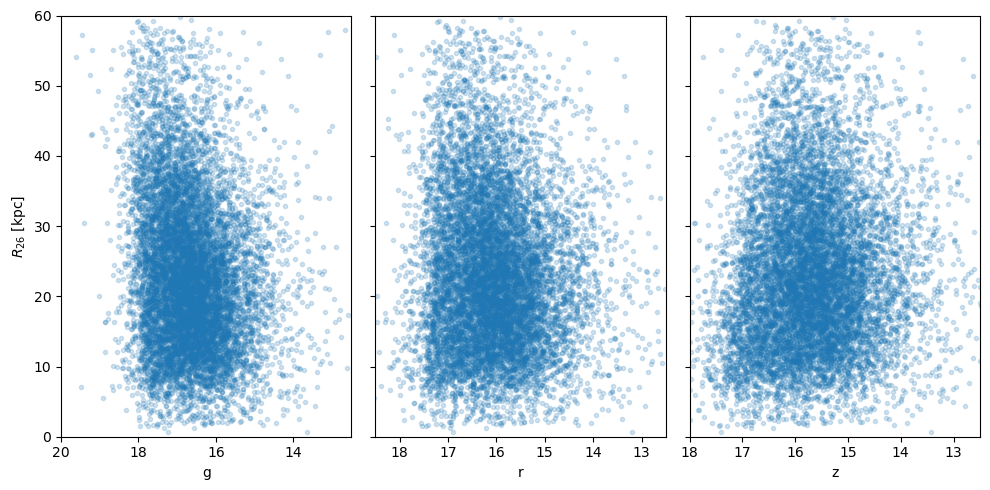

In [20]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('$R_{26}$ [kpc]')
ax[0].set_xlim([20, 12.5])
ax[0].set_ylim([0, 60])

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5]);

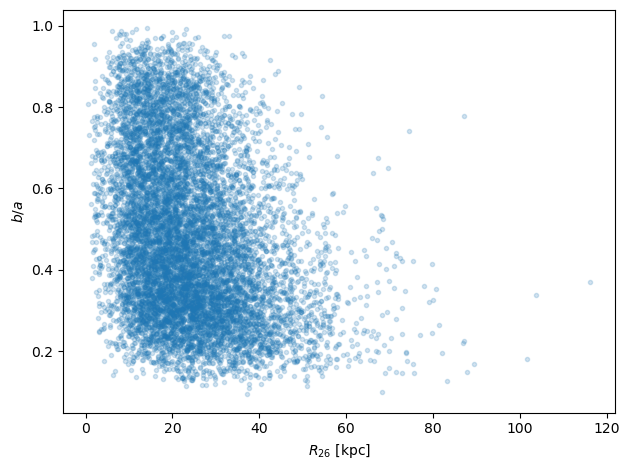

In [21]:
plt.figure(tight_layout=True)

plt.plot(gals['R26_kpc'], gals['BA'], '.', alpha=0.2)

plt.xlabel('$R_{26}$ [kpc]')
plt.ylabel('$b/a$');

## Let's try fitting a plane to ($m_r$, $b/a$, $R_{26}$)

We're going to let $x = b/a$, $y = R_{26}$, and $z = m_r$

### Calculate median $m_r$ in bins of ($b/a$, $R_{26}$)

In [40]:
ba = np.arange(0,1,0.1)
R26 = np.arange(0,80,5)
ba_grid, R26_grid = np.meshgrid(ba, R26)

mr_grid = np.nan*np.ones(ba_grid.shape)

for i in range(ba_grid.shape[1]):
    
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    
    for j in range(ba_grid.shape[0]):
        
        gals_R26_subset = gals_subset_ba[(gals_subset_ba['R26_kpc'] > j*5) & (gals_subset_ba['R26_kpc'] <= (j+1)*5)]
        
        mr_grid[j,i] = np.median(gals_R26_subset['R_MAG_SB26_CORR'])

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
# Do something to compute uncertainties in each of these bins

In [24]:
N = len(gals['R_MAG_SB26_CORR'])
N_grid = mr_grid.shape[0]*mr_grid.shape[1]

In [36]:
# Create covariance matrix, assuming each parameter is independent of the others
cov = np.empty((3, 3, N))

for i in range(N):
    cov[:,:,i] = np.array([[0.001**2, 0., 0.], [0., gals['R26_kpc_err'][i]**2, 0.], [0., 0., gals['R_MAG_SB26_ERR_CORR'][i]**2]])
    

cov_grid = np.empty((3, 3, N_grid))

for i in range(N_grid):
    cov[:,:,i] = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [26]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.251973467837832


In [37]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_grid = LinFit([np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid) - mr_median], cov_grid)

In [38]:
# Set bounds of coefficients
bounds = ((-100.0, 0.0), (-10.0, 10.0), (-100.0, 100.0), (1.0e-5, 50.))

In [39]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_grid.emcee(bounds, verbose=True)

     fun: nan
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 60165
     nit: 1000
 success: False
       x: array([36.58532429, -2.64819196, 52.96787852, 46.75889611])


ValueError: Probability function returned NaN

In [46]:
# Calculate parameter values and covariance matrix
A_ba, B_R26, C, sig = np.median(mcmc_samples, axis=1)

cov_fit = np.cov(mcmc_samples)

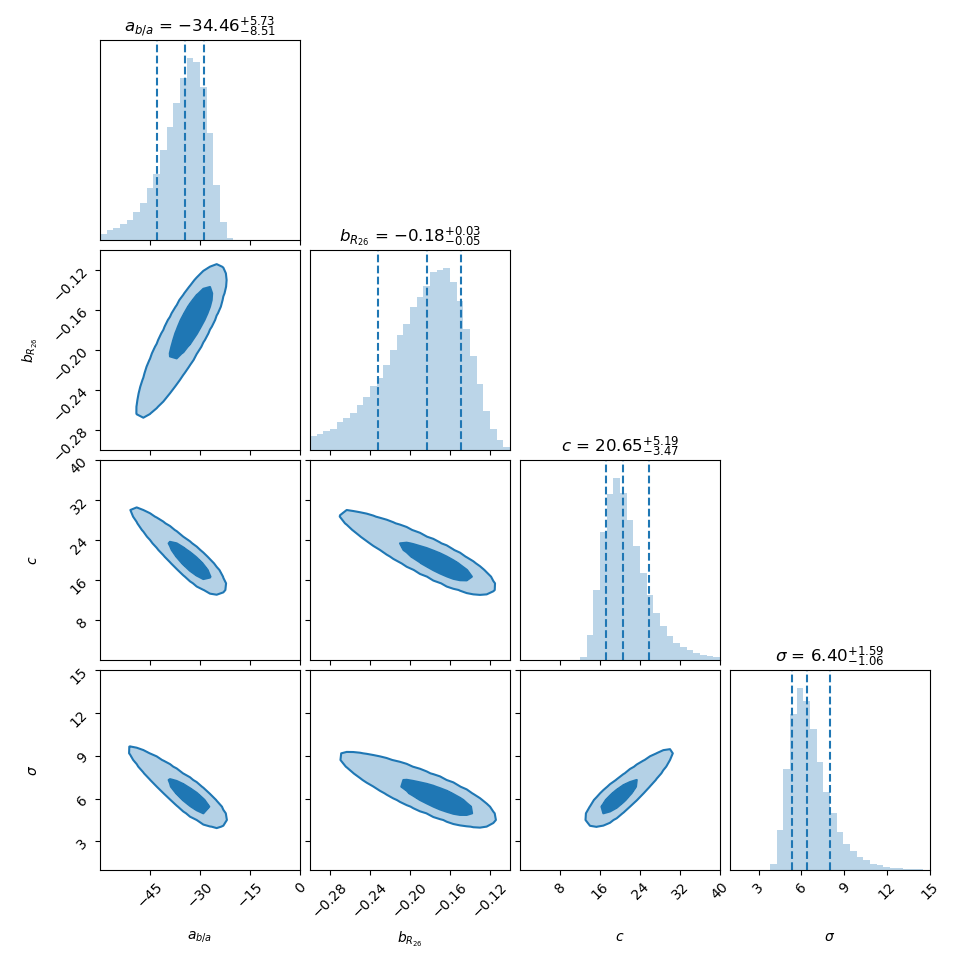

In [47]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-60, 0], [-0.3, -0.1], [0, 40], [1, 15]],
                    labels=['$a_{b/a}$', '$b_{R_{26}}$', '$c$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

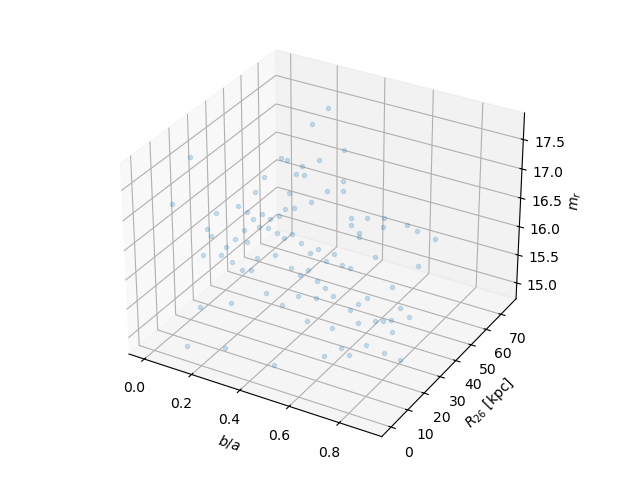

In [35]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

# ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
ax.plot(np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid), '.', alpha=0.2)

# ax.plot_wireframe(ba_grid, R26_grid, A_ba*ba_grid + B_R26*R26_grid + (C + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

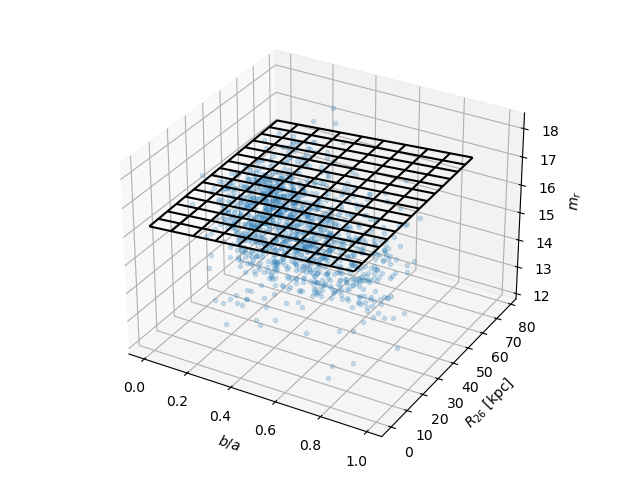

In [49]:
# Results from minimize: [0.59896149, 0.00317231, 0.01740659, 0.18515053]
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)

ax.plot_wireframe(ba_grid, R26_grid, 0.59896149*ba_grid + 0.00317231*R26_grid + (0.01740659 + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

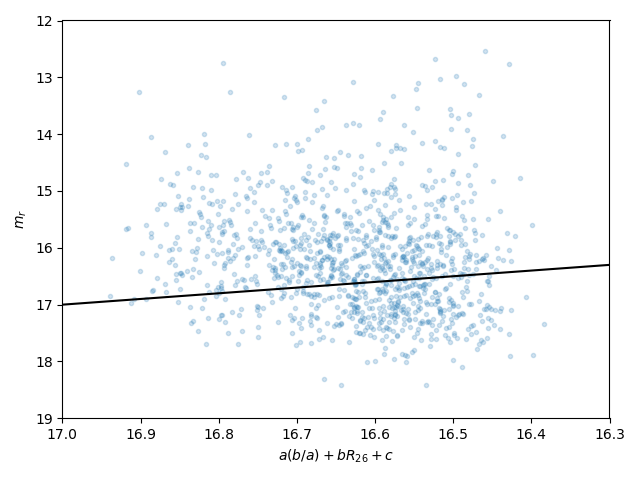

In [53]:
plt.figure(tight_layout=True)

plt.plot(0.59896149*gals['BA'] + 0.00317231*gals['R26_kpc'] + (0.01740659 + mr_median), 
         gals['R_MAG_SB26_CORR'], 
         '.', 
         alpha=0.2)

plt.plot([12, 18], [12, 18], 'k')

plt.xlim([17, 16.3])
plt.ylim([19, 12])

plt.xlabel('$a(b/a) + bR_{26} + c$')
plt.ylabel('$m_r$');

## Let's try fitting a line to ($m_r$, $b/a$)

We're going to let $x = b/a$ and $y = m_r$

In [22]:
ba = np.arange(0.1,1,0.1)

In [23]:
N = len(gals['R_MAG_SB26_CORR'])
N_bins = len(ba)

In [24]:
mr_bins = np.nan*np.ones(len(ba))
cov_bins = np.nan*np.ones((2, 2, N_bins))

for i in range(N_bins):
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    if len(gals_subset_ba) > 0:
        mr_bins[i] = np.median(gals_subset_ba['R_MAG_SB26_CORR'])
        # cov_bins[:,:,i] = np.array([[0., 0.], [0., np.std(gals_subset_ba['R_MAG_SB26_CORR'])**2]])
        # cov_bins[:,:,i] = np.array([[0., 0.], [0., np.mean((gals_subset_ba['R_MAG_SB26_CORR'] - mr_bins[i])**2)/len(gals_subset_ba)]])
        cov_bins[:,:,i] = np.array([[0., 0.], [0., 1/len(gals_subset_ba)]])

In [25]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.121483006746786


In [26]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_bins = LinFit([ba, mr_bins - mr_median], cov_bins)

In [27]:
# Set bounds of coefficients
bounds = ((-100.0, 1.0), (-1.0, 10.0), (1.0e-5, 50.))

In [28]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_bins.emcee(bounds, verbose=True)

     fun: -16.86714127173988
     jac: array([-0.0050921 ,  0.0002494 , -0.00178488])
 message: 'Optimization terminated successfully.'
    nfev: 2401
     nit: 52
 success: True
       x: array([0.20991218, 0.2500942 , 0.06330143])


100%|██████████| 1000/1000 [00:00<00:00, 2045.84it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.15411209 33.49244801 34.77936015] / 1738.968007390684


100%|██████████| 1000/1000 [00:00<00:00, 2104.51it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.828928   34.77480474 34.67461314] / 1738.7402368468702


100%|██████████| 1000/1000 [00:00<00:00, 2116.62it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.10706144 42.1835598  35.78049023] / 2405.3530719758073


100%|██████████| 1000/1000 [00:00<00:00, 2106.79it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.75479324 44.96665436 39.21766807] / 2248.3327179932153


100%|██████████| 1000/1000 [00:00<00:00, 2115.09it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.24821652 42.91962218 50.94269626] / 2547.1348132261264


100%|██████████| 1000/1000 [00:00<00:00, 2085.66it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.18004628 40.1996149  60.5061929 ] / 3025.3096448917495


100%|██████████| 1000/1000 [00:00<00:00, 2174.61it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.26575902 41.59220255 58.21352674] / 2910.6763368051415


100%|██████████| 1000/1000 [00:00<00:00, 2072.60it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.43453136 42.98816205 52.04123418] / 2602.0617089399616


100%|██████████| 1000/1000 [00:00<00:00, 2071.16it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.6773675  47.84880125 58.98172677] / 2949.0863383122723


100%|██████████| 1000/1000 [00:00<00:00, 2091.68it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [56.16015139 54.0795502  53.57362198] / 2808.007569272735


100%|██████████| 1000/1000 [00:00<00:00, 2095.98it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [61.22991394 49.35598831 53.33693939] / 3061.495696757604


100%|██████████| 1000/1000 [00:00<00:00, 2110.39it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [62.41635809 54.99018724 49.76539808] / 3120.8179045776187


100%|██████████| 1000/1000 [00:00<00:00, 2042.47it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [61.26079902 53.57850362 48.41695054] / 3063.03995117489


In [29]:
# Calculate parameter values and covariance matrix
A_ba, B, sig = np.median(mcmc_samples, axis=1)
'''
cov_fit = np.cov(mcmc_samples)
A_ba_err = np.sqrt(cov_fit[0,0])
B_err = np.sqrt(cov_fit[1,1])
'''
A_ba_err = np.std(mcmc_samples[0][(-1.5 < mcmc_samples[0]) & (mcmc_samples[0] < 0)])
B_err = np.std(mcmc_samples[1][(0 < mcmc_samples[1]) & (mcmc_samples[1] < 1)])
'''
A_ba_err = np.quantile(mcmc_samples[0], [0.16, 0.5, 0.84])
B_err = np.quantile(mcmc_samples[1], [0.16, 0.5, 0.84])
'''
print(f'{A_ba:.2f} +/- {A_ba_err:.2f}')
print(f' {B:.2f} +/- {B_err:.2f}')

-0.86 +/- 0.21
 0.44 +/- 0.14


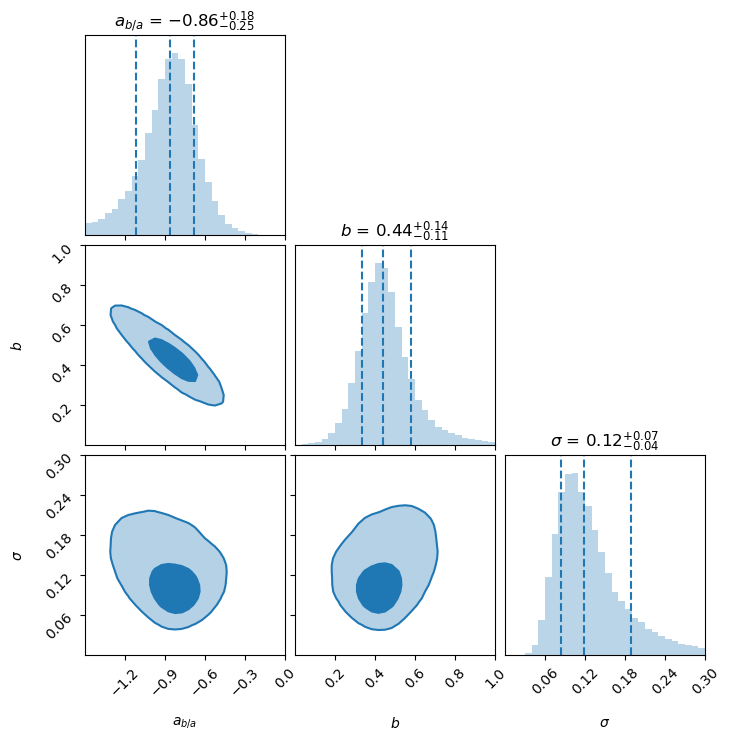

In [30]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.5, 0], [0, 1], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

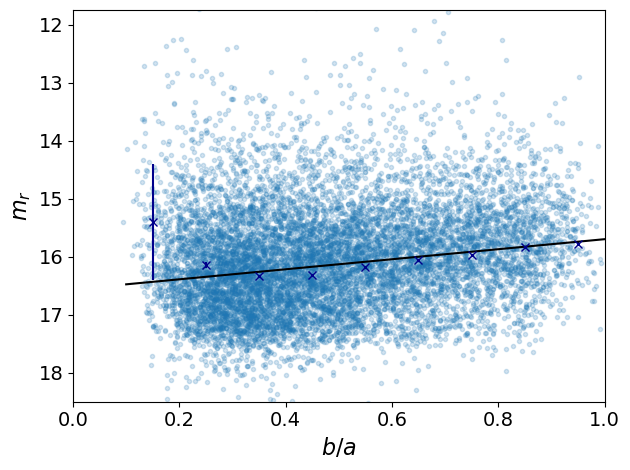

In [34]:
plt.figure(tight_layout=True)

plt.plot(gals['BA'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(ba + 0.05, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

plt.plot([0.1, 1], A_ba*np.array([0.1, 1]) + (B + mr_median), 'k')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$', fontsize=16);

plt.savefig('../../Figures/Y1/iron_internalDustCorr_z0p1_20241211.png', dpi=150, facecolor='none');

### Save MCMC chains

In [33]:
temp_outfile = open('iron_internalDust_z0p1_mcmc.pickle', 'wb')
pickle.dump((mcmc_samples, mr_median), temp_outfile)
temp_outfile.close()